In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))

In [4]:
OBS2.keys()

dict_keys(['u650', 'pgt01isvalid', 'shear', 'tmin', 'v650', 'q650', 'year', 'rh925', 'div925', 'pmax', 'pgt30', 'q925', 't925', 'tmean', 'area', 't650', 'u925', 't', 'month', 'div650', 'v925', 'p', 'pv925', 'pmean', 'w650', 'clon', 'clat', 'lon', 'pv650', 'rh650', 'lat', 'hour', 'w925'])

(array([8.7588e+04, 3.8645e+04, 2.0713e+04, 1.2476e+04, 8.5300e+03,
        6.0640e+03, 4.6990e+03, 3.6490e+03, 2.8980e+03, 2.3130e+03,
        1.8870e+03, 1.4870e+03, 1.2700e+03, 1.0380e+03, 9.3100e+02,
        7.0600e+02, 6.5300e+02, 5.3000e+02, 4.7900e+02, 3.9000e+02,
        3.0400e+02, 2.6800e+02, 2.4300e+02, 1.9900e+02, 1.7900e+02,
        1.4200e+02, 1.3300e+02, 9.7000e+01, 9.9000e+01, 8.7000e+01,
        6.3000e+01, 6.2000e+01, 5.1000e+01, 4.0000e+01, 3.0000e+01,
        2.7000e+01, 1.9000e+01, 2.8000e+01, 1.6000e+01, 1.6000e+01,
        1.6000e+01, 1.6000e+01, 1.4000e+01, 1.0000e+01, 1.0000e+01,
        6.0000e+00, 7.0000e+00, 8.0000e+00, 1.0000e+00, 8.0000e+00]),
 array([  1.  ,   2.98,   4.96,   6.94,   8.92,  10.9 ,  12.88,  14.86,
         16.84,  18.82,  20.8 ,  22.78,  24.76,  26.74,  28.72,  30.7 ,
         32.68,  34.66,  36.64,  38.62,  40.6 ,  42.58,  44.56,  46.54,
         48.52,  50.5 ,  52.48,  54.46,  56.44,  58.42,  60.4 ,  62.38,
         64.36,  66.34,  68.32

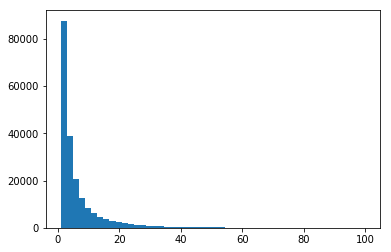

In [5]:
pp = []
for p in OBS['p']:
    pp.extend(np.array(p).flatten())
parr = np.array(pp)
plt.hist(parr, range=(1,100), bins=50)

In [6]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [7]:
obs_trmm = create_dic(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic(OBS3)

In [8]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-10)&(obs_trmm.lon<=12)&(obs_trmm.lat>=5.2)&(obs_trmm.lat<=8.3)]  #5.2 - 8.3
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.3) & (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=-10)&(obs_40.lon<=12)&(obs_40.lat>=5.2)&(obs_40.lat<=8.3)]


In [9]:
obs_gpm

,area,lat,lon,month,prcp,q650,q925,shear,t650,t925,tmean,tmin,u650,u925
0,15175,8.042260,7.086056,7,16.436291,6.616410,14.771931,4.242306,5.643030,20.572961,-59.368354,-66.000000,-0.871464,3.370841
1,8625,5.251607,11.170472,8,4.185770,7.055621,16.826462,-0.868521,5.181268,21.302759,-59.640201,-68.415718,3.606708,2.738187
2,5050,6.118873,-0.763059,11,25.979994,1.884424,15.512910,5.897785,5.504205,23.212488,-63.932756,-76.043866,-4.892231,1.005554
4,12700,5.550144,11.265918,8,16.874041,8.860437,15.085265,1.735940,5.881128,20.655878,-57.706569,-71.352158,-1.495301,0.240639
5,13525,5.638003,8.894604,7,37.000000,7.402976,15.771469,13.880902,5.241998,20.648157,-59.519781,-78.053550,-12.106024,1.774879
6,10425,6.153120,6.669265,4,2.228098,4.325093,15.239720,9.383993,5.768335,24.142786,-62.305062,-70.000000,-6.770352,2.613641
7,5350,7.869163,5.653593,7,10.723988,7.174695,14.604548,10.601906,5.975610,20.208582,-56.795472,-65.765055,-6.966541,3.635365
8,10850,5.454751,11.438341,5,14.134404,5.217465,15.294153,6.155697,7.378290,24.323053,-74.656591,-86.000000,-6.902615,-0.746918
9,10525,5.870359,8.322838,7,1.267474,6.686833,14.475948,10.404615,5.120508,23.035120,-56.181945,-67.069013,-9.873000,0.531615
11,12550,7.627684,-2.724923,10,2.670303,5.609727,14.941356,8.342429,5.652673,22.745905,-59.930664,-67.654924,-11.107446,-2.765016


In [10]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.202033158482649 8.27489747441562 -9.903745996969064 11.95447649051051
OBS_trmm 5.202948463139375 8.299489120459318 -9.985909169988865 11.952369398805448
OBS_gpm 5.200903285622903 8.299464319878636 -9.999797285878543 11.773281462182329


In [11]:
obs_trmm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

Text(0.5, 1.0, '-0.53')

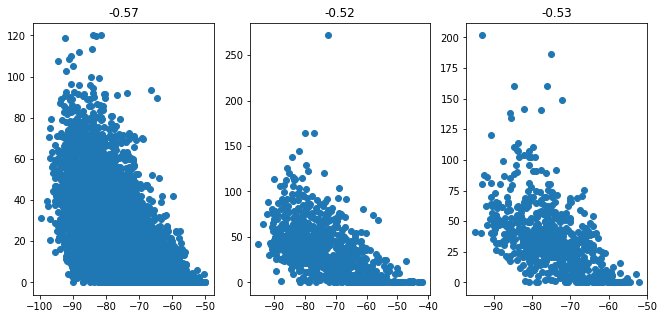

In [12]:
obss = [obs_trmm.tmin, obs_trmm.prcp]
cp4s = [obs_gpm.tmin, obs_gpm.prcp]
cp25s = [obs_40.tmin, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [13]:
tl = []
for m in range(2,12):
    try:
        dat = obs_trmm[(obs_trmm.month==m)]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 75)
    except:
        continue
    print(m,out)
    tl.append(out)

3 48.1203250770809
4 49.13789650558766
5 51.59100935992765
6 53.93305802326755
7 51.208678829315254
8 43.944735224048046
9 45.979377222321425
10 47.346190686024386
11 43.86303304587092


In [14]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 66.06542215133743
4 73.06600376704935
5 79.03739515655164
7 69.08536768565858
8 60.240459254599024
10 61.56563887655193
11 60.159213875151046


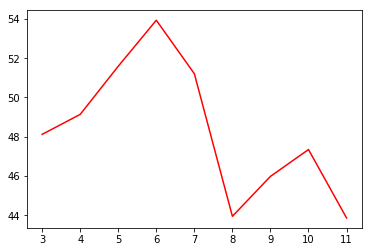

In [15]:
#plt.plot(np.arange(3,12), pl)
plt.plot(np.arange(3,12), tl, 'r')

In [16]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))

In [17]:
ts=pd.Series(np.array(era_out['dates']))

In [18]:
ts.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12])

In [19]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
ttg = np.array(era_out['tmin'])
ttm = np.array(era_out['tmean'])
lat = np.array(era_out['lat'])
lon = np.array(era_out['lon'])
area = np.array(era_out['area'])

In [20]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : ts.dt.month.values,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [21]:
ds = ds[(ds.lon>=-10)&(ds.lon<=12)&(ds.lat>=5)&(ds.lat<=8)]

In [22]:
ds = ds.dropna()

In [23]:
print(ds.lat.max(),ds.lat.min(),ds.lon.max(),ds.lon.min())
print(ds.area.min())
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

7.980003356933594 5.004997253417969 9.6300048828125 -9.970001220703125
4921.070000000001
75
4400
1452.0000000000002


In [24]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],95))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],95))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),95]))
    except:
        ptrmm40.append(np.nan)

IndexError: cannot do a non-empty take from an empty axes.

ValueError: x and y must have same first dimension, but have shapes (9,) and (4,)

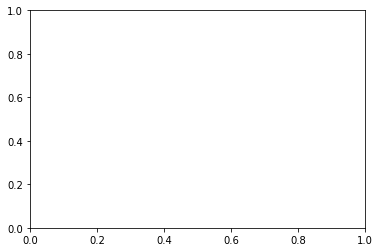

In [25]:
plt.figure()
plt.plot(range(3,12), ptrmm, '-o', label='trmm')
plt.plot(range(3,12), pgpm, '-o',label='gpm')
#plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

In [ ]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.sum((obs_trmm.month == m) & (obs_trmm.prcp>60))/np.sum((obs_trmm.month == m) & (obs_trmm.prcp>1)))
    pgpm.append(np.sum((obs_gpm.month == m) & (obs_gpm.prcp>60))/np.sum((obs_gpm.month == m) & (obs_gpm.prcp>1)))
    try:
        ptrmm40.append(np.sum((obs_40.month == m) & (obs_40.prcp>60))/np.sum((obs_40.month == m) & (obs_40.prcp>1)))
    except:
        ptrmm40.append(np.nan)

ValueError: x and y must have same first dimension, but have shapes (9,) and (4,)

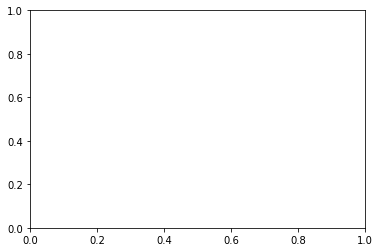

In [26]:
plt.figure()
plt.plot(range(3,12), ptrmm, 'o-',label='trmm')
plt.plot(range(3,12), pgpm, 'o-',label='gpm')
plt.plot(range(3,12), ptrmm40, 'o-',label='trmm40')
plt.legend()

In [27]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.tmin[obs_trmm.month == m],85))
    pgpm.append(np.percentile(obs_gpm.tmin[obs_gpm.month == m],85))
    gridsat.append(np.percentile(ds.tmin[ds.month == m],85))
    try:
        ptrmm40.append(np.percentile(obs_40.tmin[obs_40.month == m],85))
    except:
        ptrmm40.append(np.nan)

IndexError: cannot do a non-empty take from an empty axes.

ValueError: x and y must have same first dimension, but have shapes (9,) and (4,)

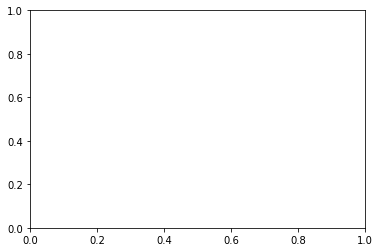

In [28]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.plot(range(3,12), gridsat, label='gridsat')
plt.legend()

In [29]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[obs_trmm.month == m],99))
    pgpm.append(np.percentile(obs_gpm.prcp[obs_gpm.month == m],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[obs_40.month == m],99))
    except:
        ptrmm40.append(np.nan)

IndexError: cannot do a non-empty take from an empty axes.

ValueError: x and y must have same first dimension, but have shapes (9,) and (4,)

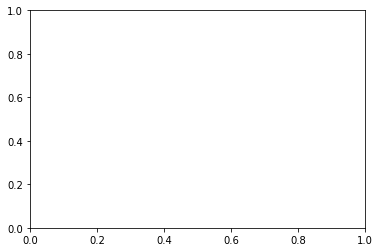

In [30]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

In [ ]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


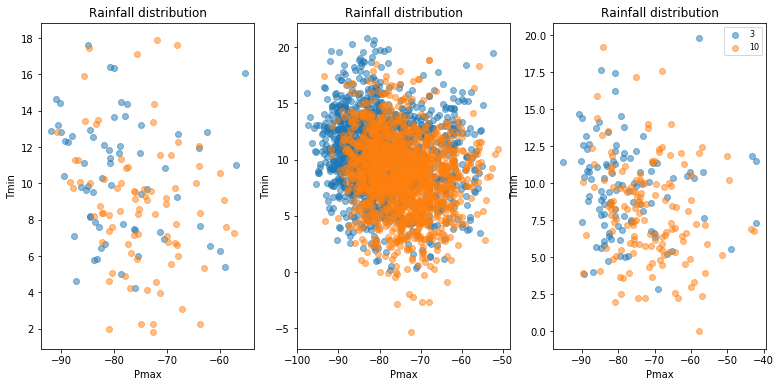

In [31]:
f = plt.figure(figsize=(13,6))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip([3,10],colors):
        #print(m)
#         if m == 5:
        monthly = (data)[data['month'] == m]
#         if m == 9:
        monthly = (data)[data['month'] == m]

        ax.scatter(monthly['tmin'], monthly['shear'], label=str(m), alpha=0.5)
    plt.ylabel('Tmin')
    #plt.xlim((0,120))
    plt.xlabel('Pmax')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


In [32]:
pos1 = (ds.u650<0) & (ds.area>=5000)# all storms, without trmm overpass - matchup via storm centre points

In [33]:
np.sum(pos1)

11481

In [34]:
oposi = (obs_gpm.u650<0) & (obs_gpm.area>=5000) & (obs_gpm.prcp>=1)# & ((obs_gpm.month>=9) | (obs_gpm.month<=5))

In [35]:
obs_gpm

,area,lat,lon,month,prcp,q650,q925,shear,t650,t925,tmean,tmin,u650,u925
0,15175,8.042260,7.086056,7,16.436291,6.616410,14.771931,4.242306,5.643030,20.572961,-59.368354,-66.000000,-0.871464,3.370841
1,8625,5.251607,11.170472,8,4.185770,7.055621,16.826462,-0.868521,5.181268,21.302759,-59.640201,-68.415718,3.606708,2.738187
2,5050,6.118873,-0.763059,11,25.979994,1.884424,15.512910,5.897785,5.504205,23.212488,-63.932756,-76.043866,-4.892231,1.005554
4,12700,5.550144,11.265918,8,16.874041,8.860437,15.085265,1.735940,5.881128,20.655878,-57.706569,-71.352158,-1.495301,0.240639
5,13525,5.638003,8.894604,7,37.000000,7.402976,15.771469,13.880902,5.241998,20.648157,-59.519781,-78.053550,-12.106024,1.774879
6,10425,6.153120,6.669265,4,2.228098,4.325093,15.239720,9.383993,5.768335,24.142786,-62.305062,-70.000000,-6.770352,2.613641
7,5350,7.869163,5.653593,7,10.723988,7.174695,14.604548,10.601906,5.975610,20.208582,-56.795472,-65.765055,-6.966541,3.635365
8,10850,5.454751,11.438341,5,14.134404,5.217465,15.294153,6.155697,7.378290,24.323053,-74.656591,-86.000000,-6.902615,-0.746918
9,10525,5.870359,8.322838,7,1.267474,6.686833,14.475948,10.404615,5.120508,23.035120,-56.181945,-67.069013,-9.873000,0.531615
11,12550,7.627684,-2.724923,10,2.670303,5.609727,14.941356,8.342429,5.652673,22.745905,-59.930664,-67.654924,-11.107446,-2.765016


In [36]:
ds_march = ds[pos1]
obsp = obs_gpm[oposi]

In [37]:
obsp.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

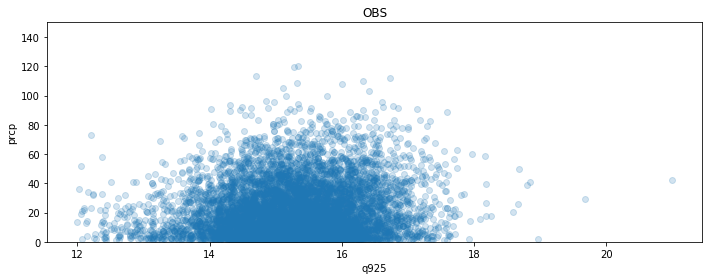

In [38]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

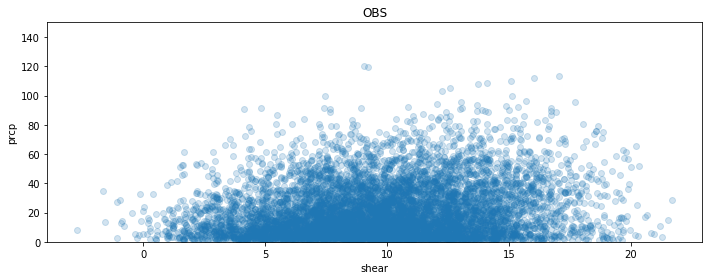

In [39]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

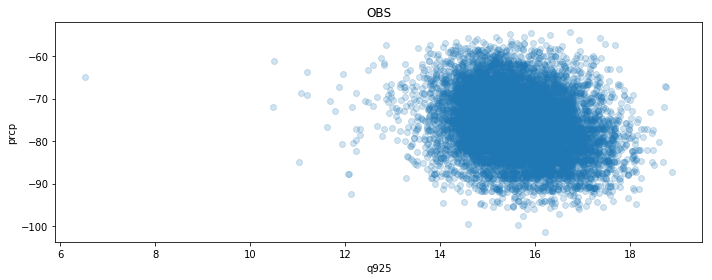

In [40]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
plt.scatter(ds_march.q925, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

In [41]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

pears (-0.18393441406991953, 4.825084630702293e-75)
(-0.17108384609747665, 5.09560688275749e-65)


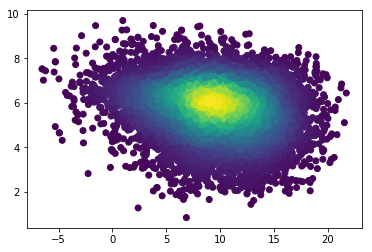

In [42]:
data, r = density_plot(obs_gpm['shear'], obs_gpm['q650'], obs_gpm['q925'])
print(u_stat.pcor(obs_gpm['shear'], obs_gpm['q650'], obs_gpm['q925']))
plt.scatter(obs_gpm['shear'], obs_gpm['q650'], c=data)

pears (0.2401298253964938, 4.2478094130827823e-128)
(0.23067872191235653, 4.399481959081886e-118)


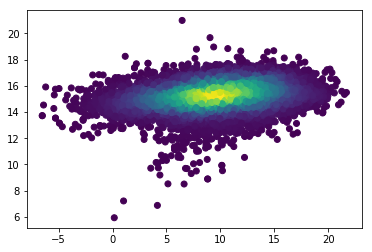

In [43]:
data, r = density_plot(obs_gpm['shear'], obs_gpm['q925'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'], obs_gpm['q925'], obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.0763816787337689, 4.106532671428383e-14)
(-0.03376049635436831, 0.0008489311691704337)


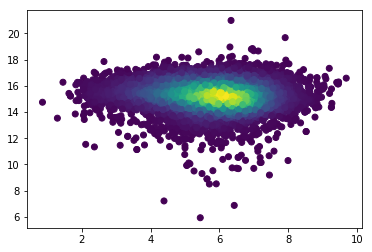

In [44]:
data, r = density_plot(obs_gpm['q650'], obs_gpm['q925'], obs_gpm['shear'])
print(u_stat.pcor(obs_gpm['q650'], obs_gpm['q925'], obs_gpm['shear']))
plt.scatter(obs_gpm['q650'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

In [45]:
thetae_up = u_met.theta_e(650,obs_gpm['t650'], obs_gpm['q650']/1000)
thetae_low = u_met.theta_e(925, obs_gpm['t925'], obs_gpm['q925']/1000)
thetae_diff = thetae_low-thetae_up

In [46]:
theta_up = u_met.theta(650,obs_gpm['t650'])
theta_low = u_met.theta(925, obs_gpm['t925'])
theta_diff = theta_low-theta_up

pears (-0.3188420590147166, 1.4022406430941522e-229)
(-0.3031378590188609, 1.2997775580456157e-206)


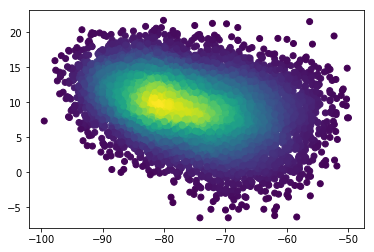

In [47]:
data, r = density_plot(obs_gpm['tmin'],obs_gpm['shear'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],obs_gpm['shear'], obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], obs_gpm['shear'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.21937258886388677, 1.0355727271561374e-106)
(-0.19244951258384035, 4.2538163310084295e-82)


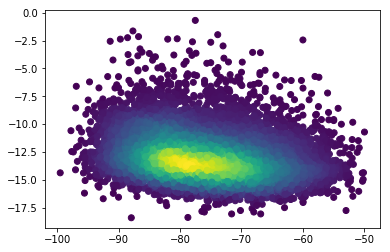

In [48]:
data, r = density_plot(obs_gpm['tmin'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.2898249878512807, 2.882462611923161e-188)
(-0.33269692778411225, 5.563722365900645e-251)


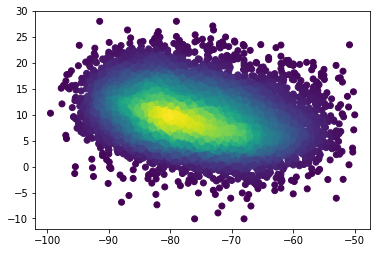

In [49]:
data, r = density_plot(obs_gpm['tmin'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.15190059157277302, 1.73378473075937e-51)
(0.10481079981677105, 2.9502332328910444e-25)


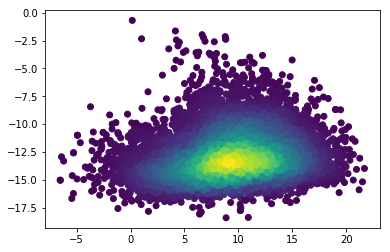

In [50]:
data, r = density_plot(obs_gpm['shear'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.307515735386926, 6.871814579367657e-213)
(0.2816005215699286, 2.1790633046904977e-177)


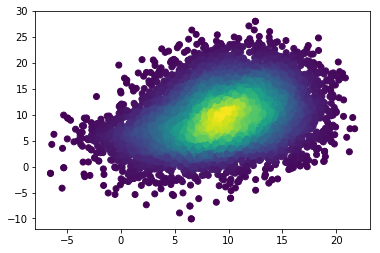

In [51]:
data, r = density_plot(obs_gpm['shear'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.18393441406991953, 4.825084630702293e-75)
(-0.17108384609747665, 5.09560688275749e-65)


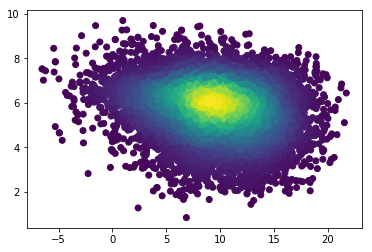

In [52]:
data, r = density_plot(obs_gpm['shear'],obs_gpm['q650'], obs_gpm['q925'])
print(u_stat.pcor(obs_gpm['shear'],obs_gpm['q650'], obs_gpm['q925']))
plt.scatter(obs_gpm['shear'], obs_gpm['q650'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.0355727595744391, 0.00043857631473872)
(-0.02252884864610451, 0.026012468600932415)


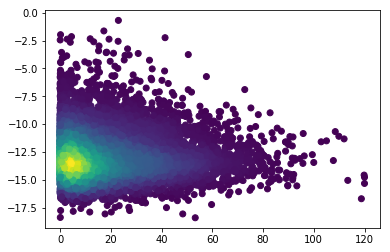

In [53]:
data, r = density_plot(obs_gpm['prcp'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['prcp'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.0007696011982139207, 0.9393897862517567)
(0.07022341054443966, 3.749511667330926e-12)


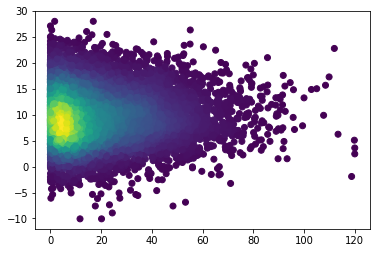

In [54]:
data, r = density_plot(obs_gpm['prcp'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['prcp'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.16330055974520272, 2.4919102474639533e-59)
(0.17079284363528496, 8.416804030248967e-65)


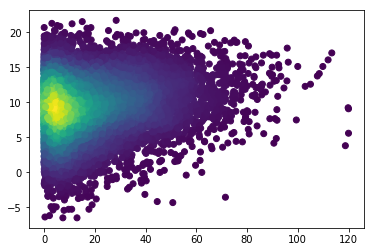

In [55]:
data, r = density_plot(obs_gpm['prcp'],obs_gpm['shear'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],obs_gpm['shear'], theta_diff))
plt.scatter(obs_gpm['prcp'], obs_gpm['shear'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.0913796772537485, 1.465832520739943e-19)
(0.08590003349387387, 1.859783783632588e-17)


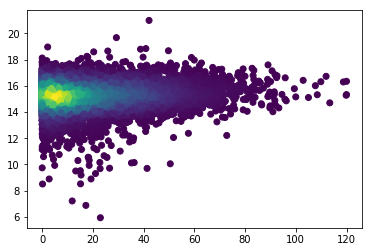

In [56]:
data, r = density_plot(obs_gpm['prcp'],obs_gpm['q925'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],obs_gpm['q925'], theta_diff))
plt.scatter(obs_gpm['prcp'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

In [57]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.area, dat.tmin, dat.u925)

    mappable = ax2.scatter(dat.area, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('area')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [58]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

In [59]:
ds_march.keys()

Index(['area', 'lat', 'lon', 'month', 'q700', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

pears (0.28159407312022644, 3.0969563776485213e-208)
pears (-0.23970457036192488, 9.769560699663986e-150)
pears (0.2188844826887362, 1.4201238170932914e-124)
pears (-0.4249520844609414, 0.0)


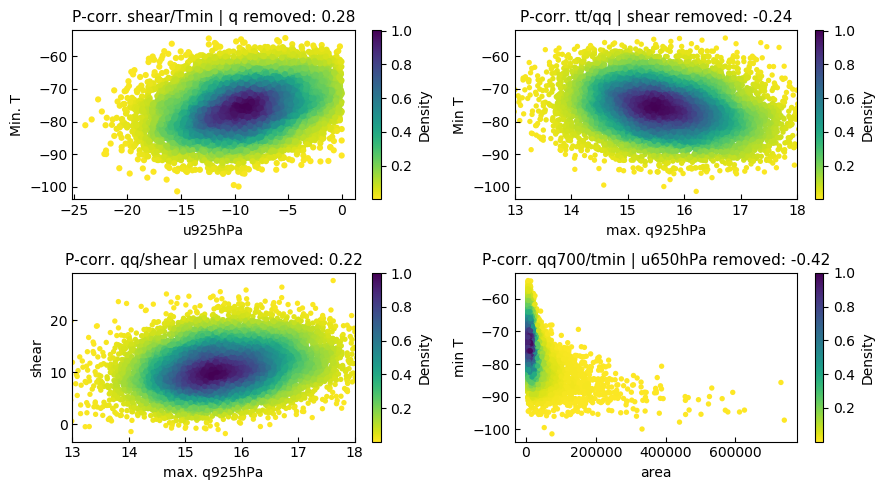

In [60]:
plot_scatter_month(ds_march)

pears (0.35905843992887343, 7.271060829400771e-251)
pears (-0.26558649300363596, 6.450512658893652e-134)
pears (0.20217182117119067, 3.113156307357145e-77)
pears (-0.4492534411560584, 0.0)


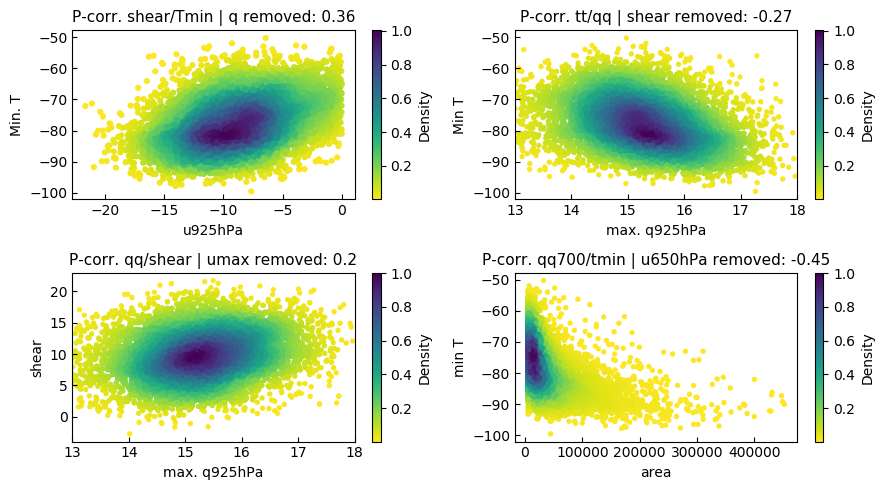

In [61]:
plot_scatter_month(obsp)

In [62]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 1 #5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, 2) , np.percentile(ds_march.q925, p2), nbq) 

nbqq = 7
nbss = 7

p1 = 1
p2 = 99

shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,p1)) & (obsp.shear<=np.percentile(obsp.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, 2) , np.percentile(obsp.q925, 99), nbqq)


In [63]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [64]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [65]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [66]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [67]:
def hist2d_three(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,4))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,3,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [68]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [69]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

In [70]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

10.781728921405445
15.630504314872617


In [107]:
tmin_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Median minimum temperature',
    'valid' : dsval_mar,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
    'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Median maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],2),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],97),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : dsarea_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],1),
    'vmax' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [108]:
shearscat = np.repeat(shear_obsp,pcobs.shape[0],axis=0).reshape(pcobs.shape)

In [109]:
deltaPS = []
for sh in np.unique(shearscat):
        vals = pcobs[sh==shearscat]
        deltaPS.append(np.nanmax(vals)-np.nanmin(vals))
print(deltaPS)

[6.847265517818976, 7.517670043381393, 4.399630310733194, 6.895285390328908, 6.576880584961607, 6.598766088044556, nan]


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


0.8840827451260601
0.8191000328259023


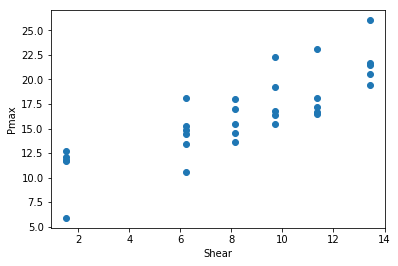

In [110]:
plt.scatter(shearscat, pcobs)
plt.xlabel('Shear')
plt.ylabel('Pmax')
shearfin = shearscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
slope, intercept, r_value, p_value, std_err = stats.linregress(shearfin, pfin)
print(slope)
print(r_value)

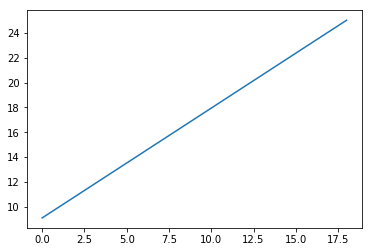

In [111]:
plt.plot(intercept+slope*range(19))

2.6606037343485545
0.811275348034823


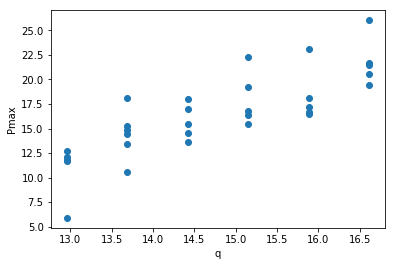

In [112]:
qscat = np.repeat(qbinso,pcobs.shape[0],axis=0).reshape(pcobs.shape)
plt.scatter(qscat, pcobs)
plt.xlabel('q')
plt.ylabel('Pmax')
qfin = qscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qfin, pfin)
print(qslope)
print(qr_value)

In [113]:
deltaPQ = []
for sh in np.unique(qscat):
        vals = pcobs[sh==qscat]
        deltaPQ.append(np.nanmax(vals)-np.nanmin(vals))
print(deltaPQ)

[6.847265517818976, 7.517670043381393, 4.399630310733194, 6.895285390328908, 6.576880584961607, 6.598766088044556, nan]


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.


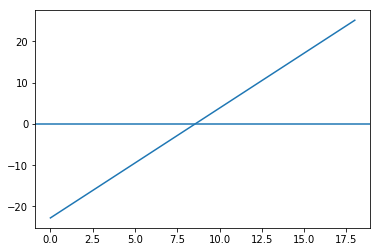

In [114]:
plt.plot(qintercept+qslope*range(19))
plt.axhline(0)

In [115]:
# sensitivity = {}
# sensitivity['shear_slope'] = slope
# sensitivity['qslope'] = qslope 
# pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

(array([  50.,  496., 1628., 2853., 2936., 2104., 1029.,  311.,   69.,
           5.]),
 array([-1.8368516 ,  1.10604668,  4.04894495,  6.99184322,  9.9347415 ,
        12.87763977, 15.82053804, 18.76343632, 21.70633459, 24.64923286,
        27.59213114]),
 <a list of 10 Patch objects>)

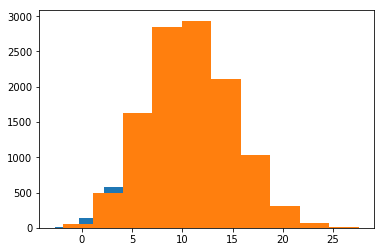

In [116]:
plt.hist(obsp.shear)
plt.hist(ds_march.shear)

In [117]:
data_list = [tmin_dic, prcp_dic, area_dic]

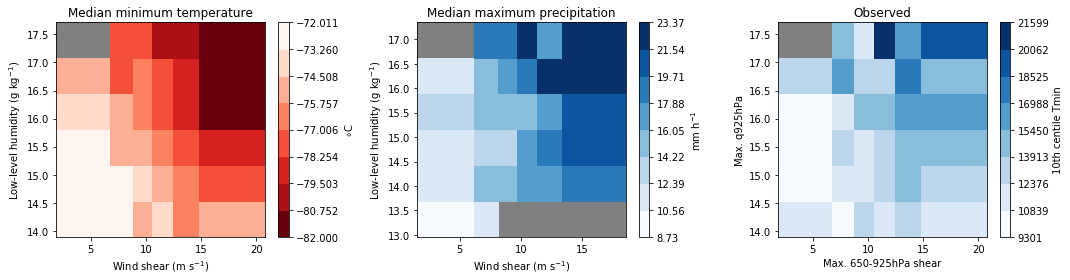

In [118]:
hist2d_three(data_list, valid=True)

[ 2.71988095  5.46242285  6.97131252  7.98212997  8.92596491  9.8711586
 10.79320566 11.89270481 13.02416606 14.65079105 18.62344635]
bigger than 2.719880952835083
smaller than 5.462422847747803
bigger than 5.462422847747803
smaller than 6.971312522888184
bigger than 6.971312522888184
smaller than 7.982129970550539
bigger than 7.982129970550539
smaller than 8.925964908599854
bigger than 8.925964908599854
smaller than 9.871158599853516
bigger than 9.871158599853516
smaller than 10.793205661773683
bigger than 10.793205661773683
smaller than 11.892704811096191
bigger than 11.892704811096191
smaller than 13.024166061401367
bigger than 13.024166061401367
smaller than 14.65079104614258
bigger than 14.65079104614258
smaller than 18.623446350097648


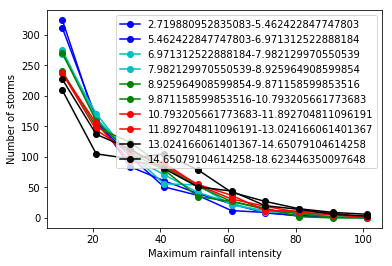

In [248]:
p = np.array(obsp.shear)
t = np.array(obsp.prcp)
q = np.array(obsp.q925)


bins = np.percentile(p[p>=2], np.linspace(1,99,11))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>=55) / np.sum(t[pos]>=1)
    qprob = np.sum(q[pos]>=17.5) / np.sum(q[pos]>=12)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

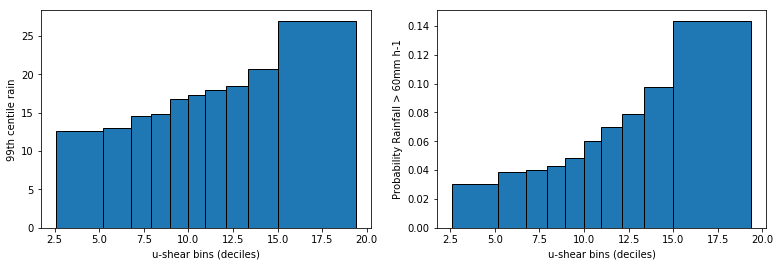

In [194]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

bar_dic = {
'xtick' : xtick,
'ytick' : pprob,
'width' : xtickwidth
}

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

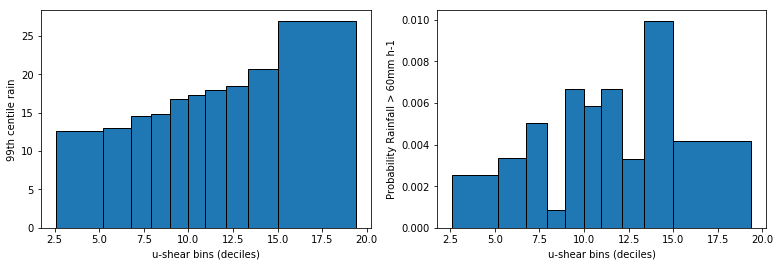

In [195]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

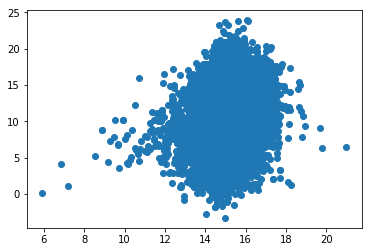

In [196]:
plt.scatter(obsp.q925, obsp.shear)

In [197]:
np.percentile(obsp.prcp[obsp.prcp>1],90)

48.182952705166976

[13.00113648 14.2642241  14.6046613  14.85800464 15.07426457 15.2975563
 15.5248167  15.81093296 16.19775221 20.99131607]
bigger than 13.001136481761932
smaller than 14.264224097132683
bigger than 14.264224097132683
smaller than 14.604661303261917
bigger than 14.604661303261917
smaller than 14.85800463706255
bigger than 14.85800463706255
smaller than 15.074264568587145
bigger than 15.074264568587145
smaller than 15.297556295990944
bigger than 15.297556295990944
smaller than 15.524816699326038
bigger than 15.524816699326038
smaller than 15.810932964086533
bigger than 15.810932964086533
smaller than 16.197752207517624
bigger than 16.197752207517624
smaller than 20.991316065192223


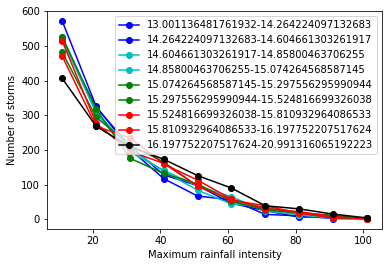

In [198]:
p = np.array(obsp.q925)
t = np.array(obsp.prcp)
q = np.array(obsp.shear)


bins = np.percentile(p[p>=13], np.linspace(0,100,10))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>55) / np.sum(t[pos]>1)
    qprob = np.sum(q[pos]>=18) / np.sum(q[pos]>=0)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

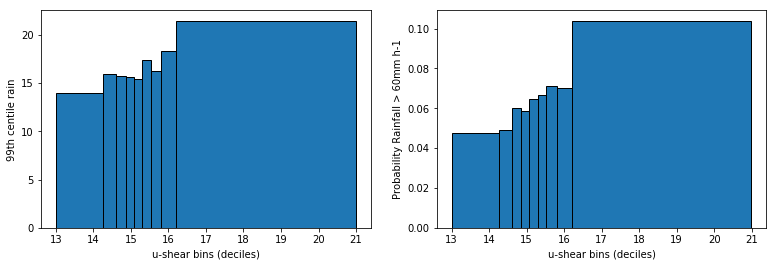

In [199]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

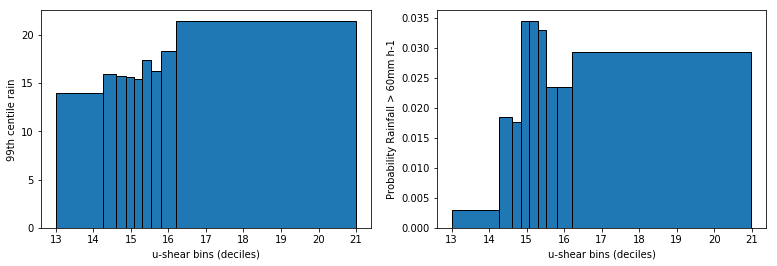

In [200]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

In [201]:
u_stat.pcor(obsp.prcp, obsp.q925,obsp.shear)

(0.07071963458205903, 2.3763935187721906e-15)

In [202]:
u_stat.pcor(obsp.prcp, obsp.shear,obsp.q925)

(0.18519440665679815, 5.94009227102951e-97)

In [203]:
def sort_vars():
    q925 = np.array(obsp.shear)
    shears = np.array(obsp.q925)

    sort = np.argsort(q925)
    q = q925[sort]

    shear = shears[sort]
    tmin = np.array(obsp.prcp)[sort]
    
    linsp = np.linspace(0,len(q925)-1,12)
    #linsp = np.percentile(q925[q925>=2], np.linspace(0,99,11))
    
    inds = np.round(linsp).astype(int)

    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qsample = q[inds[start]:end]
        qmean.append( np.min(qsample)+ (np.max(qsample)-np.min(qsample))/2)
        
            

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])
        print(shear[inds[start]], shear[end])
#         ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
#         corr.append(ttslope) 
        corr.append(rc)
        qcorr.append(ttslope) 
    return qmean, corr, qcorr

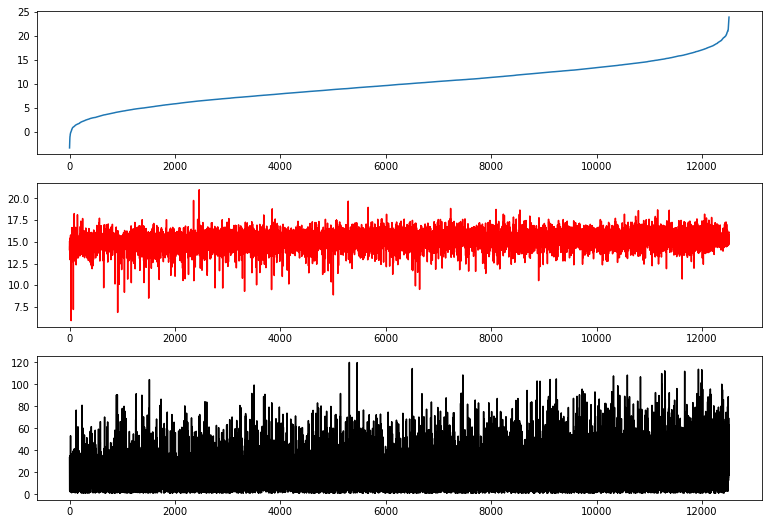

15.002934262156487 14.506226405501366
14.65659961104393 14.635846950113773
14.506226405501366 14.7705702111125
14.635846950113773 15.197194181382656
14.7705702111125 15.019943937659264
15.197194181382656 14.749817550182343
15.019943937659264 14.59774374961853
14.749817550182343 15.636065974831581
14.59774374961853 16.839049756526947
15.636065974831581 16.07629656791687


In [204]:
qmean, corr, slope = sort_vars()

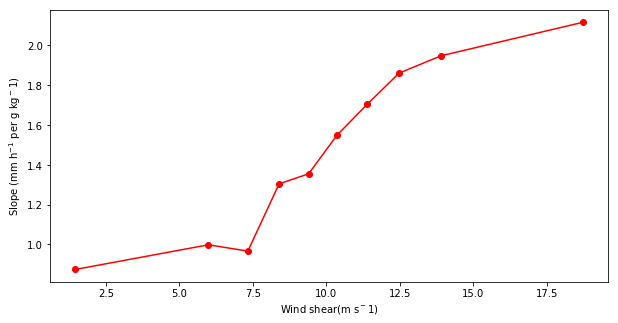

In [205]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,slope, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
slope_dic = {
'xtick' : qmean,
'ytick' : slope,
}

Text(0, 0.5, 'Slope (mm h$^{-1}$ per g kg$^-1$)')

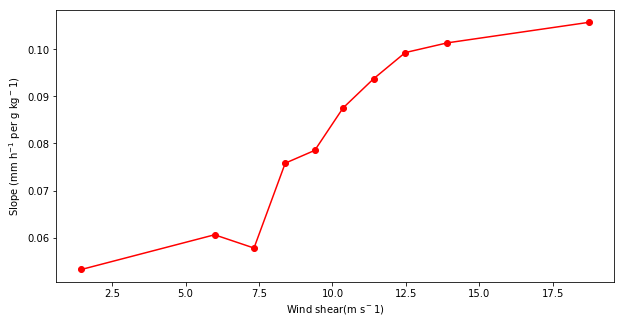

In [206]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,corr, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')

In [207]:
def hist2d_bar(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(5,10))
    text = ['(a)', '(b)', '(c)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(3,1,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(313)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black')
    ax4.set_xlabel('650-925hPa wind shear (m s$^{-1}$)')
    ax4.set_ylabel('Probability rainfall > 55mm h$^{-1}$ (%)')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
    


    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.97), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.02, 0.64), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.315), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
#plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly.png')

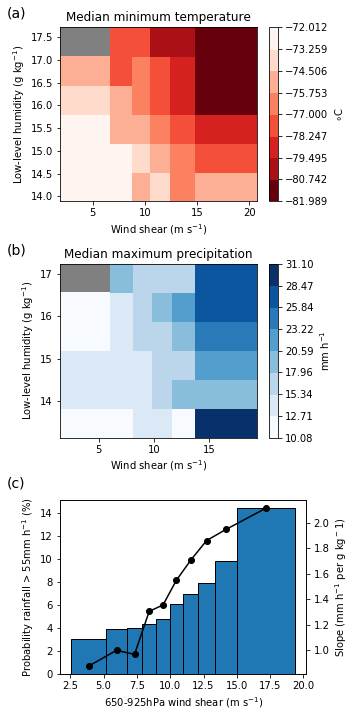

In [208]:
data_list = [tmin_dic, prcp_dic]
hist2d_bar(data_list, bar_dic, slope_dic, valid=False)

In [132]:
obs_gpm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

pears (0.17303823108920208, 1.1153329215854625e-101)


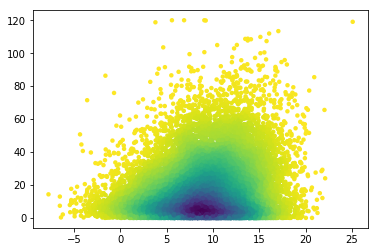

In [139]:
dat = obs_gpm
data1, r1 = density_plot(dat.shear, dat.prcp, dat.q925)

plt.scatter(dat.shear, dat.prcp, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r

In [75]:
rainlist = []
for rain in OBS['p']:
    
    rainlist.extend(rain.flat)

In [76]:
len(rainlist)
rain = np.array(rainlist)

In [77]:
np.percentile(rain[rain>1],95)

22.52128280644234

In [78]:
np.percentile(obs_gpm.prcp[obs_gpm.prcp>1],95)

55.66187893957572

In [79]:
dQ = pkl.load(open(cnst.network_data + 'data/CLOVER/saves/deltaQ_plot.p',
                           'rb'))

In [80]:
dQ

{'deltaqy': array([ 0.0501999 ,  0.03189941, -0.040171  ,  0.10085453,  0.19249202,
         0.3573268 ,  0.629571  ,  0.51972616,  0.45858485,  0.6206908 ],
       dtype=float32),
 'tminstd': array([-68.48999023, -69.314991  , -70.38499832, -70.79998779,
        -71.02999878, -71.72999573, -72.54499054, -73.13749695,
        -73.68998718, -74.25999451]),
 'tminx': array([ 5.566946,  7.212179,  8.460169,  9.554464, 10.559965, 11.570615,
        12.676903, 13.901707, 15.342691, 17.408857], dtype=float32),
 'tminy': array([-72.96999359, -74.12499237, -74.80499268, -75.18998718,
        -75.72999573, -76.48999023, -77.38999939, -78.33999634,
        -78.81999207, -79.39499664])}

In [81]:
x = np.array(dQ['tminx'])
corr_all = np.array(dQ['deltaqy'])

qcorr_all = np.array(dQ['tminy'])
qcorr_all_std = np.array(dQ['tminstd'])

In [88]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
    ax4.set_xlabel('Wind shear (m s$^{-1}$)')
    ax4.set_ylabel('%')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
    ax5.text(0.01,0.8,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
    ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)
    
    ax6 = f.add_subplot(223)
    ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
    ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
    ax7 = ax6.twinx()
    ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
    ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
    #ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
    ax7.set_ylim(-85,-70)
    ax7.set_ylim(ax7.get_ylim()[::-1])
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('g kg$^{-1}$')
    ax7.set_ylabel(r'${\circ}$C')
    ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
    ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_deltaQ.png')

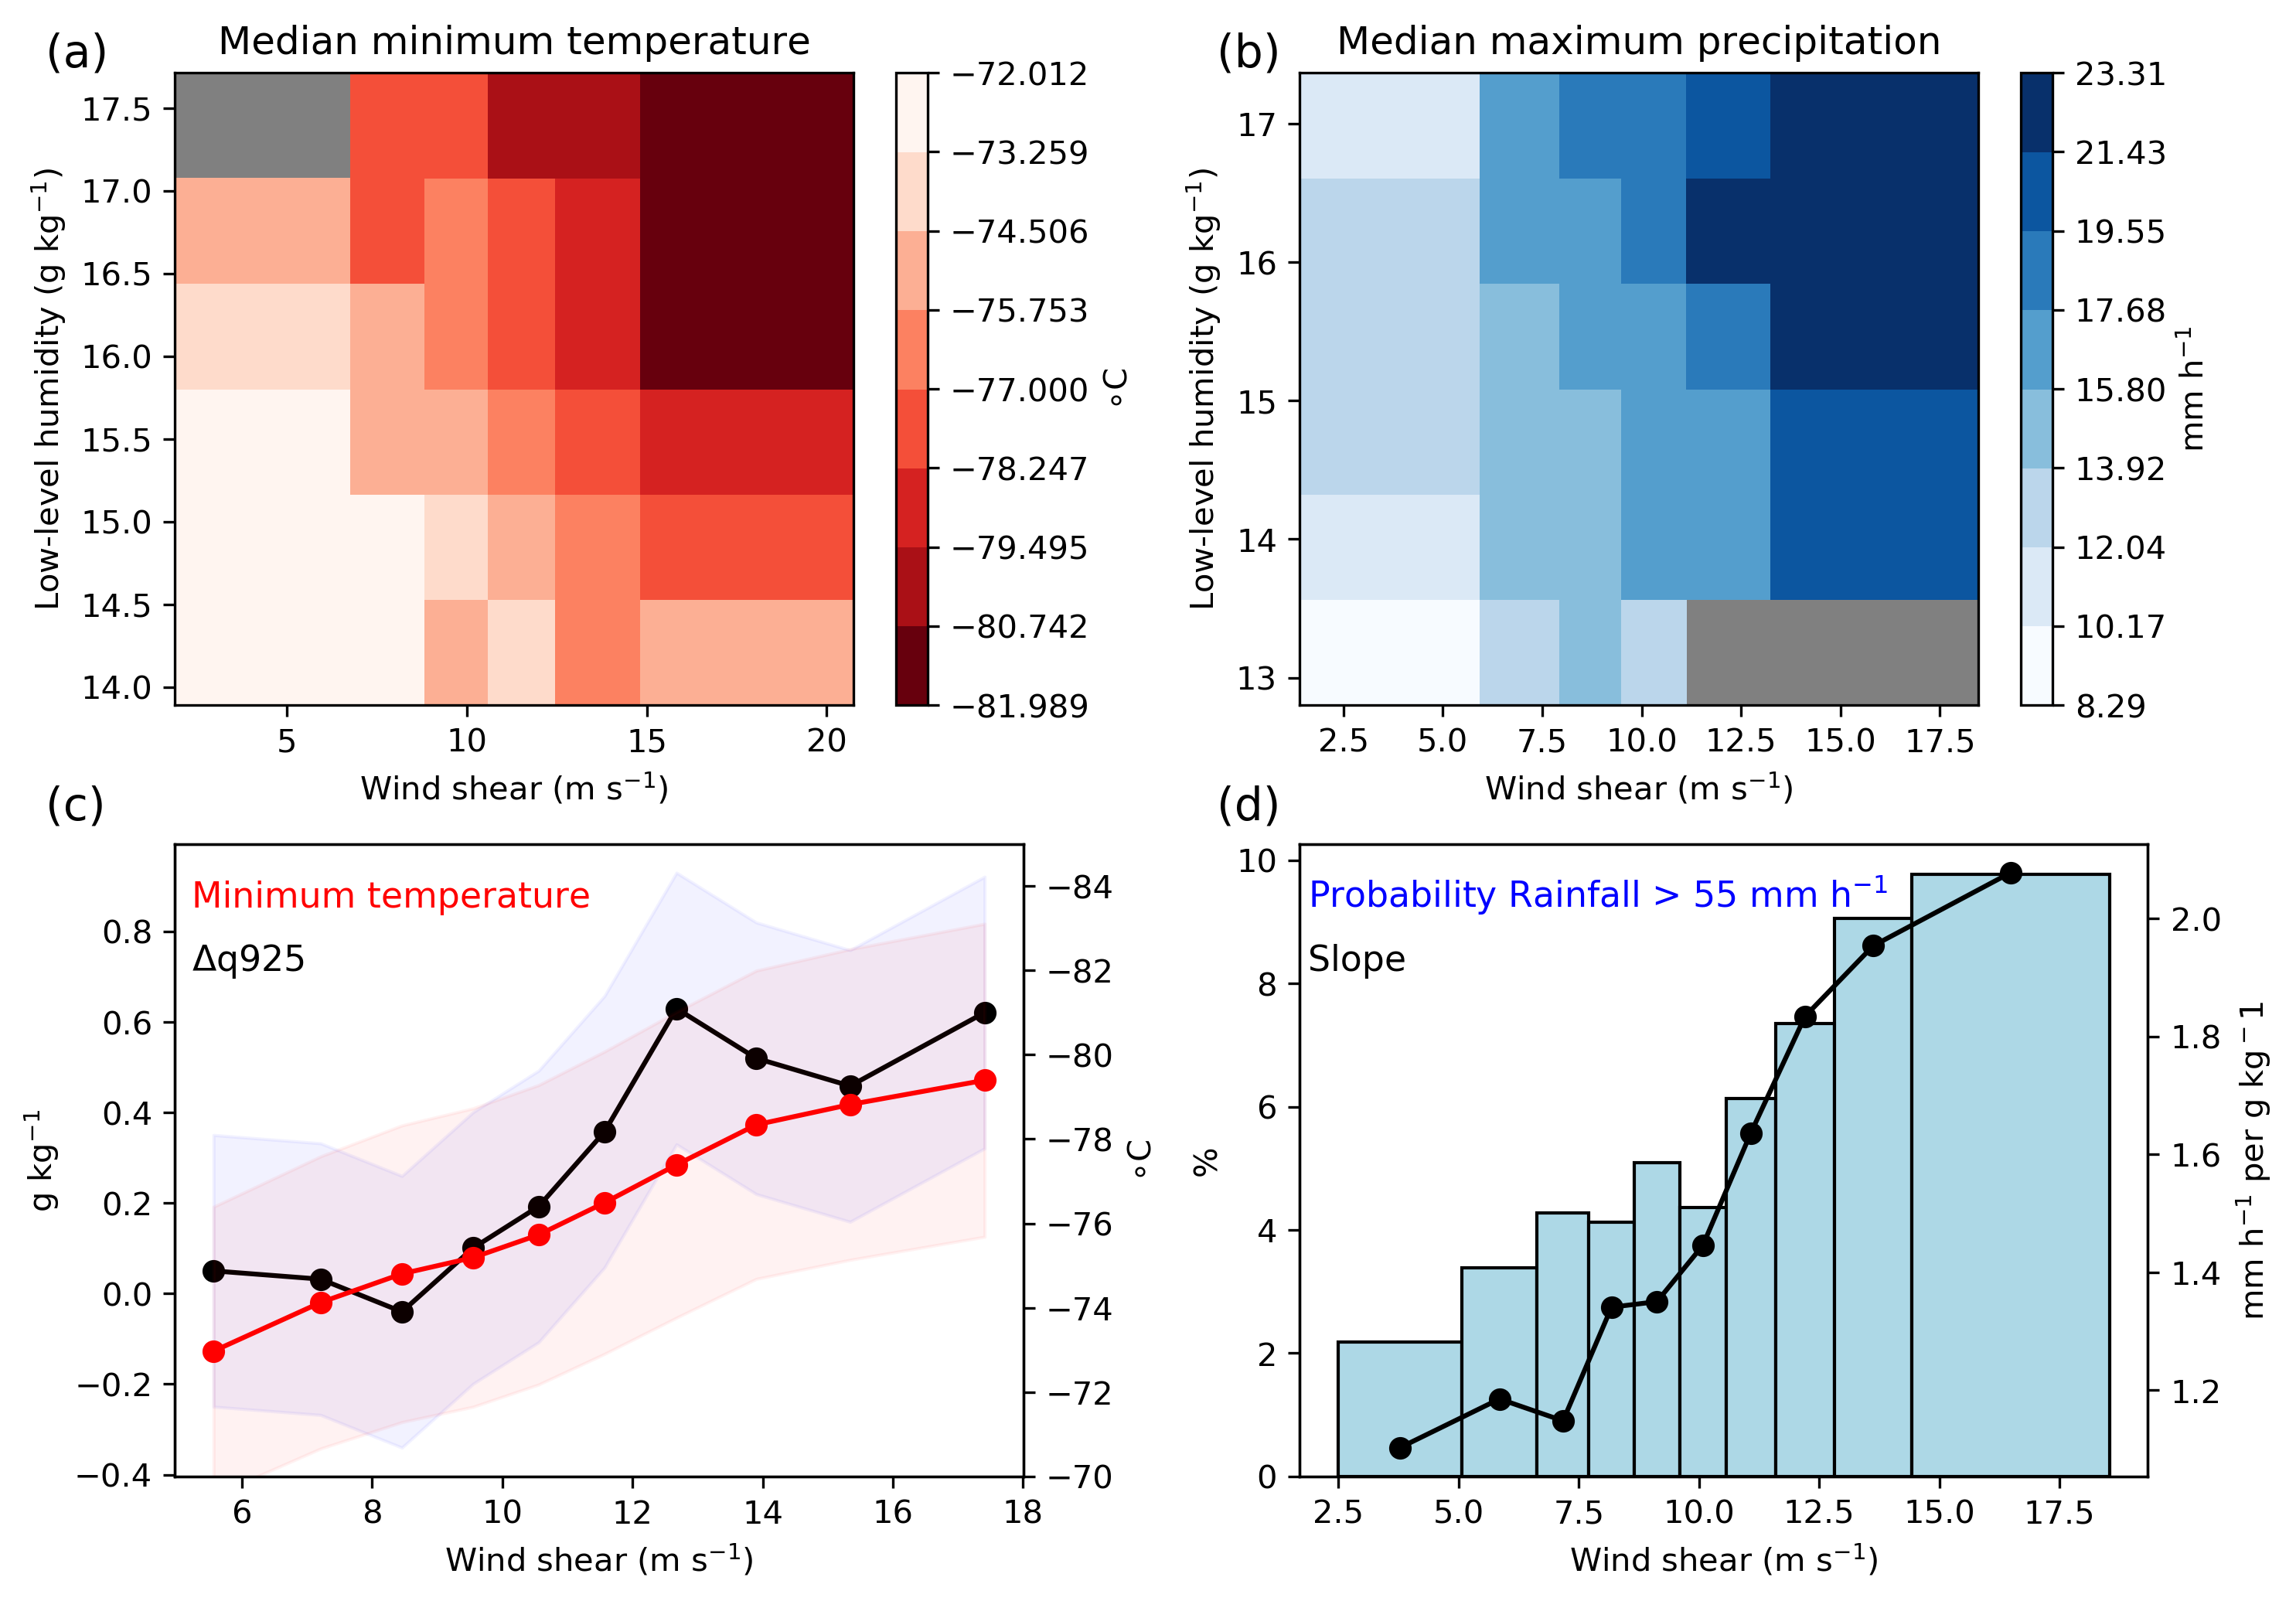

In [89]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

In [418]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,4), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    
 #   plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist.png')
        
 

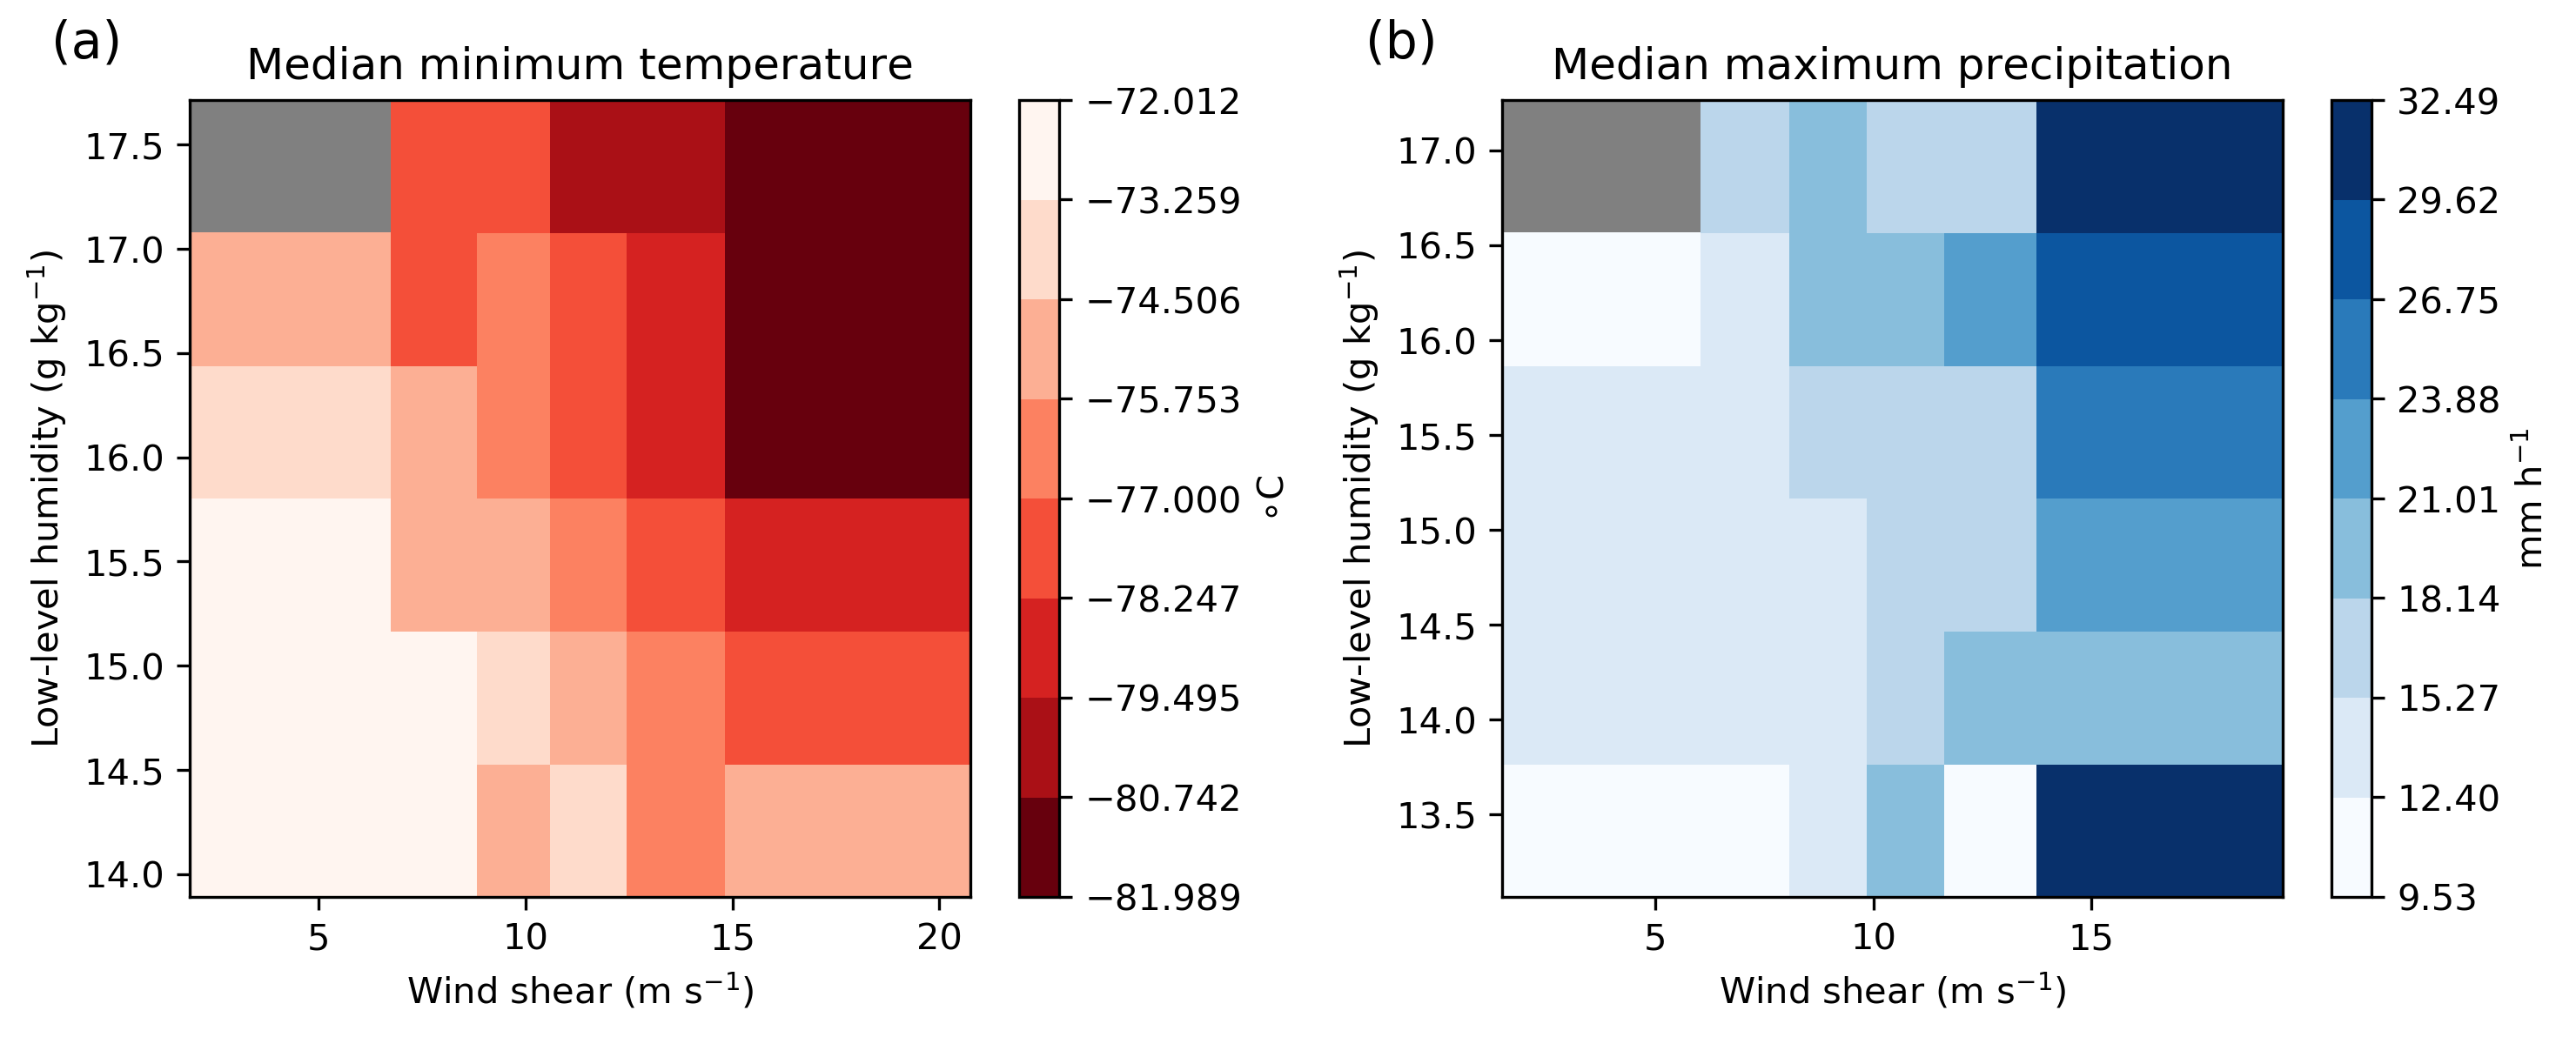

In [419]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

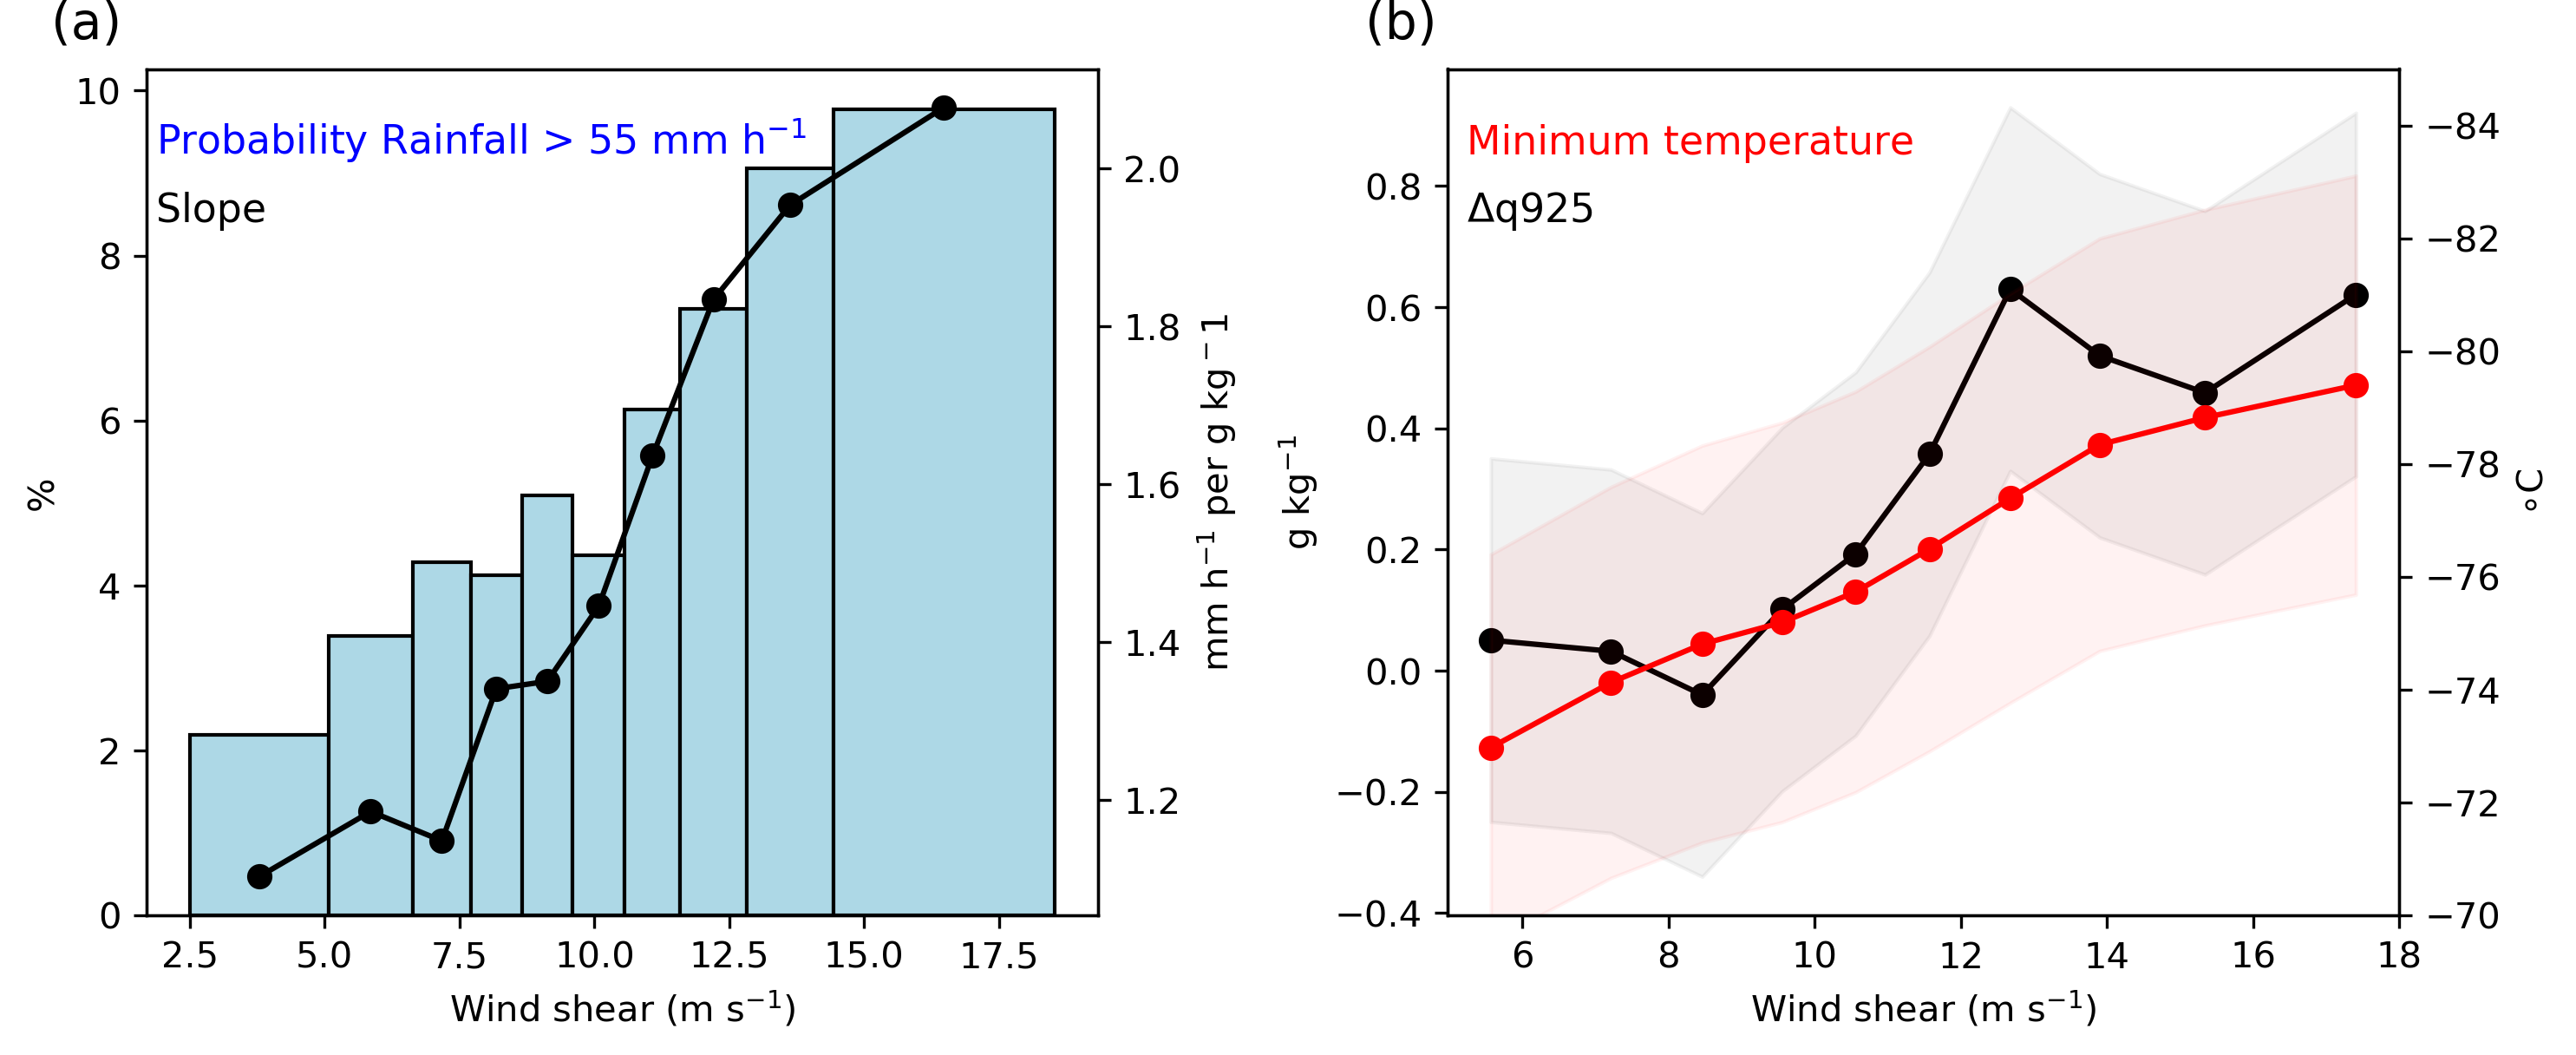

In [105]:
bar = bar_dic
slope = slope_dic

f = plt.figure(figsize=(10,4), dpi=300)
text = ['(a)', '(b)', '(a)', '(b)']
ax4 = f.add_subplot(121)
ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
ax4.set_xlabel('Wind shear (m s$^{-1}$)')
ax4.set_ylabel('%')

ax5 = ax4.twinx()
ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
ax5.set_xlabel('Wind shear(m s$^-1$)')
ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
ax5.text(0.01,0.82,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)

ax6 = f.add_subplot(122)
ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='k', alpha=0.05)
ax7 = ax6.twinx()
ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax7.set_ylim(-85,-70)
ax7.set_ylim(ax7.get_ylim()[::-1])
ax6.set_xlabel('Wind shear (m s$^{-1}$)')
ax6.set_ylabel('g kg$^{-1}$')
ax7.set_ylabel(r'${\circ}$C')
ax6.text(0.02,0.82,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

plt.tight_layout()
plt.annotate(text[2], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate(text[3], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist_part2.png')